In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_14(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_14, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
    

        x = torch.relu(self.layer3(x))
        

        x = torch.relu(self.layer4(x))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_14(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:18:05,821] A new study created in memory with name: no-name-f99cb06f-48fd-45f5-9dad-72399957f590
/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:20:50,975] Trial 0 finished with value: 0.17919744387838185 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.0002126612033645583, 'weight_decay': 0.0004281266628855525}. Best is trial 0 with value: 0

Early stopping at epoch 48
Final MCC: 0.1792


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:21:31,251] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.002339154252561104, 'weight_decay': 0.00011977988111677582}. Best is trial 0 with value: 0.17919744387838185.


Early stopping at epoch 11
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:23:04,393] Trial 2 finished with value: 0.29818767909364446 and parameters: {'dropout1': 0.4, 'dropout2': 0.45, 'learning_rate': 0.0007221821466412762, 'weight_decay': 0.0014268201043563158}. Best is trial 2 with value: 0.29818767909364446.


Early stopping at epoch 27
Final MCC: 0.2982


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:24:49,282] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0002300082964916935, 'weight_decay': 0.0066639479941959755}. Best is trial 2 with value: 0.29818767909364446.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:25:44,299] Trial 4 finished with value: 0.29685993184495857 and parameters: {'dropout1': 0.45, 'dropout2': 0.0, 'learning_rate': 0.003852136712490171, 'weight_decay': 0.00013905795394081506}. Best is trial 2 with value: 0.29818767909364446.


Early stopping at epoch 15
Final MCC: 0.2969


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:25:47,804] Trial 5 pruned. 
[I 2024-12-04 16:25:51,243] Trial 6 pruned. 
[I 2024-12-04 16:25:54,631] Trial 7 pruned. 
[I 2024-12-04 16:25:58,089] Trial 8 pruned. 
[I 2024-12-04 16:26:01,608] Trial 9 pruned. 
[I 2024-12-04 16:26:04,953] Trial 10 pruned. 
[I 2024-12-04 16:26:08,322] Trial 11 pruned. 
[I 2024-12-04 16:26:11,665] Trial 

Early stopping at epoch 39
Final MCC: 0.1290


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:28:33,287] Trial 15 pruned. 
[I 2024-12-04 16:28:36,642] Trial 16 pruned. 
[I 2024-12-04 16:28:40,001] Trial 17 pruned. 
[I 2024-12-04 16:29:49,954] Trial 18 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.4, 'learning_rate': 0.0015031722077258015, 'weight_decay': 0.00981822602928768}. Best is trial 2 with 

Early stopping at epoch 19
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:29:53,566] Trial 19 pruned. 
[I 2024-12-04 16:29:57,161] Trial 20 pruned. 
[I 2024-12-04 16:30:00,840] Trial 21 pruned. 
[I 2024-12-04 16:30:04,446] Trial 22 pruned. 
[I 2024-12-04 16:30:08,000] Trial 23 pruned. 
[I 2024-12-04 16:32:40,698] Trial 24 finished with value: 0.2984928778269346 and parameters: {'dropout1': 0.5, 'dropout2'

Early stopping at epoch 43
Final MCC: 0.2985


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:32:44,247] Trial 25 pruned. 
[I 2024-12-04 16:37:09,423] Trial 26 finished with value: 0.3117538231685599 and parameters: {'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011193248395252305, 'weight_decay': 0.00362947455688143}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 73
Final MCC: 0.3118


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:17,519] Trial 27 finished with value: 0.29179414386485275 and parameters: {'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00010968336826407585, 'weight_decay': 0.0038044679870774616}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 50
Final MCC: 0.2918


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:21,236] Trial 28 pruned. 
[I 2024-12-04 16:43:28,932] Trial 29 finished with value: 0.2633297623254712 and parameters: {'dropout1': 0.5, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001484039806655693, 'weight_decay': 0.006450149972554286}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 50
Final MCC: 0.2633


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:43:32,583] Trial 30 pruned. 
[I 2024-12-04 16:46:18,937] Trial 31 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 0.00010079416277366808, 'weight_decay': 0.005564105930370486}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 45
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:46:22,756] Trial 32 pruned. 
[I 2024-12-04 16:46:26,615] Trial 33 pruned. 
[I 2024-12-04 16:46:30,400] Trial 34 pruned. 
[I 2024-12-04 16:46:34,131] Trial 35 pruned. 
[I 2024-12-04 16:47:24,678] Trial 36 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.002893834737946148, 'weight_decay':

Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:47:28,292] Trial 37 pruned. 
[I 2024-12-04 16:47:31,876] Trial 38 pruned. 
[I 2024-12-04 16:47:35,492] Trial 39 pruned. 
[I 2024-12-04 16:47:39,115] Trial 40 pruned. 
[I 2024-12-04 16:47:42,739] Trial 41 pruned. 
[I 2024-12-04 16:52:00,081] Trial 42 finished with value: 0.29191145879250335 and parameters: {'dropout1': 0.4, 'dropout2

Early stopping at epoch 69
Final MCC: 0.2919


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:52:03,850] Trial 43 pruned. 
[I 2024-12-04 16:54:56,827] Trial 44 finished with value: 0.13794926124656237 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 0.00012125512107063399, 'weight_decay': 0.0011945032340702857}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 45
Final MCC: 0.1379


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:55:00,574] Trial 45 pruned. 
[I 2024-12-04 16:55:04,296] Trial 46 pruned. 
[I 2024-12-04 16:55:07,998] Trial 47 pruned. 
[I 2024-12-04 16:55:11,720] Trial 48 pruned. 
[I 2024-12-04 16:55:15,501] Trial 49 pruned. 
[I 2024-12-04 16:55:19,229] Trial 50 pruned. 
[I 2024-12-04 16:57:51,042] Trial 51 finished with value: 0.293673926994192

Early stopping at epoch 40
Final MCC: 0.2937


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:02:05,677] Trial 52 finished with value: 0.2975707485197976 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00010065354959355276, 'weight_decay': 0.0018891544617244524}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 67
Final MCC: 0.2976


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:02:09,536] Trial 53 pruned. 
[I 2024-12-04 17:04:14,779] Trial 54 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 0.00013236226960502758, 'weight_decay': 0.0017570183320141954}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:06:57,686] Trial 55 finished with value: 0.3045662781080955 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.00010013210633510253, 'weight_decay': 0.005074860657960297}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 42
Final MCC: 0.3046


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:07:01,499] Trial 56 pruned. 
[I 2024-12-04 17:07:05,385] Trial 57 pruned. 
[I 2024-12-04 17:07:09,238] Trial 58 pruned. 
[I 2024-12-04 17:07:13,107] Trial 59 pruned. 
[I 2024-12-04 17:07:17,015] Trial 60 pruned. 
[I 2024-12-04 17:10:42,170] Trial 61 finished with value: 0.2724782962121822 and parameters: {'dropout1': 0.45, 'dropout2

Early stopping at epoch 57
Final MCC: 0.2725


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:10:45,581] Trial 62 pruned. 
[I 2024-12-04 17:10:49,012] Trial 63 pruned. 
[I 2024-12-04 17:10:52,437] Trial 64 pruned. 
[I 2024-12-04 17:10:55,879] Trial 65 pruned. 
[I 2024-12-04 17:10:59,302] Trial 66 pruned. 
[I 2024-12-04 17:11:02,705] Trial 67 pruned. 
[I 2024-12-04 17:11:06,124] Trial 68 pruned. 
[I 2024-12-04 17:11:09,542] T

Early stopping at epoch 84
Final MCC: 0.2732


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:16:02,569] Trial 74 pruned. 
[I 2024-12-04 17:16:05,662] Trial 75 pruned. 
[I 2024-12-04 17:16:08,762] Trial 76 pruned. 
[I 2024-12-04 17:18:23,271] Trial 77 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 0.00011388753628898596, 'weight_decay': 0.0020848865483601847}. Best is trial 26 wi

Early stopping at epoch 43
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:18:26,394] Trial 78 pruned. 
[I 2024-12-04 17:18:29,462] Trial 79 pruned. 
[I 2024-12-04 17:18:32,571] Trial 80 pruned. 
[I 2024-12-04 17:20:30,090] Trial 81 finished with value: 0.2984928778269346 and parameters: {'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011398285283610529, 'weight_decay': 0.0044266551

Early stopping at epoch 37
Final MCC: 0.2985


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:22:33,522] Trial 82 finished with value: 0.29685993184495857 and parameters: {'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011272357824505157, 'weight_decay': 0.004275915963779416}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 39
Final MCC: 0.2969


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:22:36,643] Trial 83 pruned. 
[I 2024-12-04 17:22:39,734] Trial 84 pruned. 
[I 2024-12-04 17:22:42,873] Trial 85 pruned. 
[I 2024-12-04 17:26:09,016] Trial 86 finished with value: 0.2633297623254712 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.00010858832894637644, 'weight_decay': 0.00953317411441642}. Best 

Early stopping at epoch 66
Final MCC: 0.2633


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:26:12,156] Trial 87 pruned. 
[I 2024-12-04 17:26:45,915] Trial 88 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.05, 'learning_rate': 0.001517389159640343, 'weight_decay': 0.008240706873703115}. Best is trial 26 with value: 0.3117538231685599.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:26:48,984] Trial 89 pruned. 
[I 2024-12-04 17:26:52,072] Trial 90 pruned. 
[I 2024-12-04 17:26:55,151] Trial 91 pruned. 
[I 2024-12-04 17:26:58,239] Trial 92 pruned. 
[I 2024-12-04 17:27:01,350] Trial 93 pruned. 
[I 2024-12-04 17:30:35,470] Trial 94 finished with value: 0.29072133077420836 and parameters: {'dropout1': 0.45, 'dropout

Early stopping at epoch 67
Final MCC: 0.2907


/tmp/ipykernel_283437/4210310411.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_283437/4210310411.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:30:38,673] Trial 95 pruned. 
[I 2024-12-04 17:30:41,850] Trial 96 pruned. 
[I 2024-12-04 17:30:45,017] Trial 97 pruned. 
[I 2024-12-04 17:30:48,212] Trial 98 pruned. 
[I 2024-12-04 17:30:51,402] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011193248395252305, 'weight_decay': 0.00362947455688143}
Best Validation F1:  0.3117538231685599


Epoch [1/100], Loss: 0.6579
Epoch [1/100], Train Loss: 0.6579, Val Loss: 0.6048
Epoch [2/100], Loss: 0.6023
Epoch [2/100], Train Loss: 0.6023, Val Loss: 0.5830
Epoch [3/100], Loss: 0.5875
Epoch [3/100], Train Loss: 0.5875, Val Loss: 0.5792
Epoch [4/100], Loss: 0.5814
Epoch [4/100], Train Loss: 0.5814, Val Loss: 0.5771
Epoch [5/100], Loss: 0.5768
Epoch [5/100], Train Loss: 0.5768, Val Loss: 0.5759
Epoch [6/100], Loss: 0.5760
Epoch [6/100], Train Loss: 0.5760, Val Loss: 0.5764
Epoch [7/100], Loss: 0.5727
Epoch [7/100], Train Loss: 0.5727, Val Loss: 0.5748
Epoch [8/100], Loss: 0.5714
Epoch [8/100], Train Loss: 0.5714, Val Loss: 0.5730
Epoch [9/100], Loss: 0.5685
Epoch [9/100], Train Loss: 0.5685, Val Loss: 0.5738
Epoch [10/100], Loss: 0.5705
Epoch [10/100], Train Loss: 0.5705, Val Loss: 0.5710
Epoch [11/100], Loss: 0.5698
Epoch [11/100], Train Loss: 0.5698, Val Loss: 0.5720
Epoch [12/100], Loss: 0.5651
Epoch [12/100], Train Loss: 0.5651, Val Loss: 0.5713
Epoch [13/100], Loss: 0.5715
Epoch

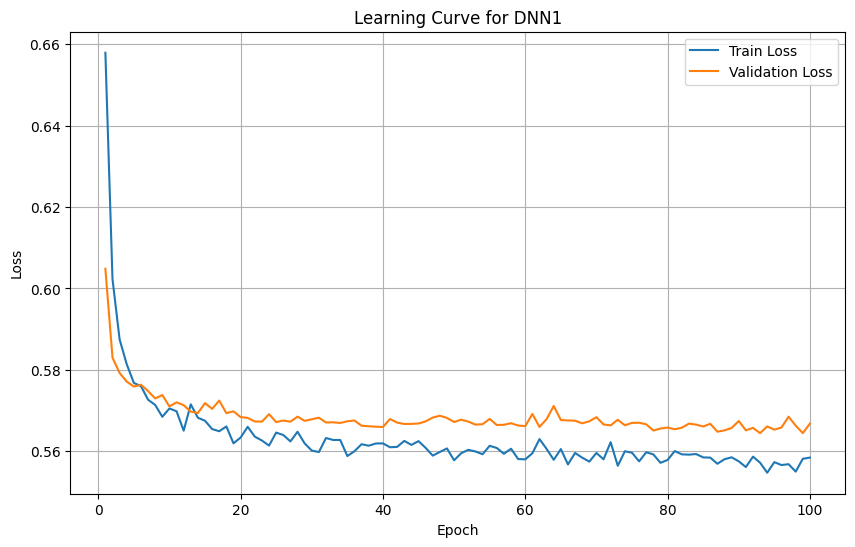

In [13]:
best_params=study.best_params
model = DNN_14(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.54%
Precision: 0.4797
Recall: 0.8702
F1 Score: 0.6184
Matthews Correlation Coefficient: 0.2939
Specificity: 0.4063


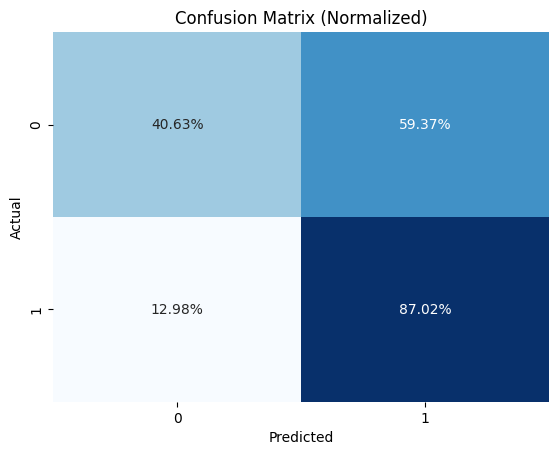

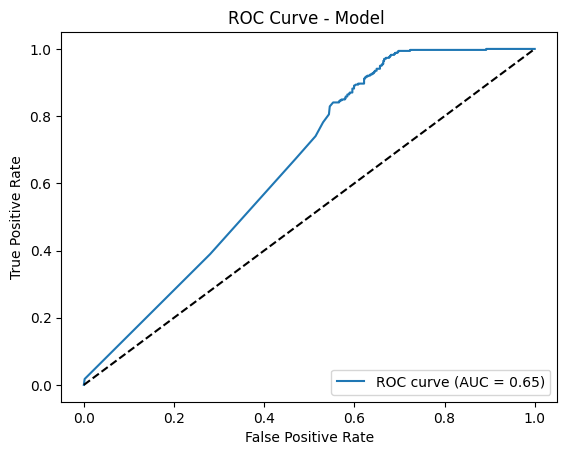

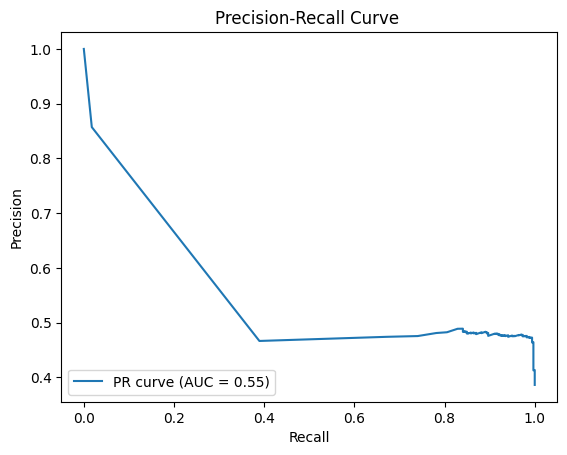

In [16]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_14.pth')

